### Define configuration files

In [22]:
from box.sim_box import SimulationBox
from potential.force import Force
from cell.cell import Cell
from substrate.substrates import Substrate
from helper_functions import helper_functions as hf
from visuals.figure import Figure
from polarity import polarity

import matplotlib.pyplot as plt
import glob
import pandas as pd
import numpy as np
import os
import time
from importlib import reload

reload(polarity)

from cell import cell

reload(cell)
from cell.cell import Cell


im_kwargs = {"origin": "lower", "extent": [0, 50, 0, 50]}

### Some random functions

In [23]:
def _masked(arr, masker):
    arr_masked = np.ones(arr.shape) * np.nan
    i, j = np.where(masker >= 0.5)
    arr_masked[i, j] = arr[i, j]
    return arr_masked


def plot_probs(cell, p1, p2, p, c, time, p_ratio):
    cntr = cell.contour[0][:, ::-1]

    if not isinstance(p1, np.ndarray):
        p1 = np.array([p1] * cntr.shape[0])

    if not isinstance(p2, np.ndarray):
        p2 = np.array([p2] * cntr.shape[0])

    plt.figure(figsize=(6, 6))
    plt.subplot(221)
    plt.title("filopodia")
    plt.scatter(cntr[:, 0], cntr[:, 1], c=p1, cmap="coolwarm")
    plt.colorbar()

    plt.subplot(222)
    plt.title("feedback")
    plt.scatter(cntr[:, 0], cntr[:, 1], c=p2, cmap="coolwarm")
    plt.colorbar()
    plt.scatter(*c, color="black", s=20)

    plt.subplot(223)
    plt.title("total")
    plt.scatter(cntr[:, 0], cntr[:, 1], c=p, cmap="coolwarm")
    plt.colorbar()

    plt.subplot(224)
    plt.title("Tension")
    plt.plot(time, p_ratio)
    plt.xlabel("Time")
    plt.ylabel(r"$P/P_0$")

    plt.subplots_adjust(wspace=1, hspace=0.7)
    plt.show()

### Initialize system

In [24]:
def _build_system(simbox, cell_config, cell_rng_seed):
    # unpack
    N_mesh, L_box = simbox.N_mesh, simbox.L_box

    # define base substrate
    sub_config = simbox.sub_config
    sub_dim = simbox.sub_config["sub_sep"]
    xi = sub_config["xi"]
    kind = sub_config["kind"]
    # buffer = sub_config["buffer"]
    sub = Substrate(N_mesh, L_box, xi)
    if kind == "two-state":
        chi = sub.two_state_sub(bridge_width=17, delta_centers=sub_dim)
    elif kind == "rectangular":
        chi = sub.rectangular()
    else:
        raise ValueError(f"{kind} for substrate is not understood.")

    # initialize cells
    # set the cumulative substrate they will interact with
    cell = Cell(cell_config[0], simbox, cell_rng_seed)
    cell.W = 0.5 * cell.g * chi

    return cell, chi


def _define_paths(gid):
    SIMBOX_CONFIG = f"../configs/IM/grid_id{gid}/simbox.yaml"
    ENERGY_CONFIG = "../configs/energy.yaml"

    CELL_CONFIG = [f"../configs/IM/grid_id{gid}/cell.yaml"]

    return dict(
        simbox=SIMBOX_CONFIG,
        energy=ENERGY_CONFIG,
        cell=CELL_CONFIG,
    )


def _mvg_generator(cell):
    import numpy as np
    from polarity.mvgaussian import MVGaussian

    N_mesh = cell.simbox.N_mesh
    d = np.linspace(0, N_mesh, N_mesh)
    x, y = np.meshgrid(d, d)
    X = np.array(list(zip(x.flatten(), y.flatten())))

    cell.mvg_gen = MVGaussian(X)

In [25]:
# define various paths
gid = 81
paths = _define_paths(gid)

# initialize the simulation box
simbox = SimulationBox(paths["simbox"])
seed = int(time.time())
cell, chi = _build_system(simbox, paths["cell"], cell_rng_seed=seed)

# initialize the force calculator
force_calculator = Force(paths["energy"])

# noise patch -- init MVG generator for the cell
_mvg_generator(cell)

(75.25029443096534, 99.3050076757714, 87.46936084516945, 111.5305089193058)

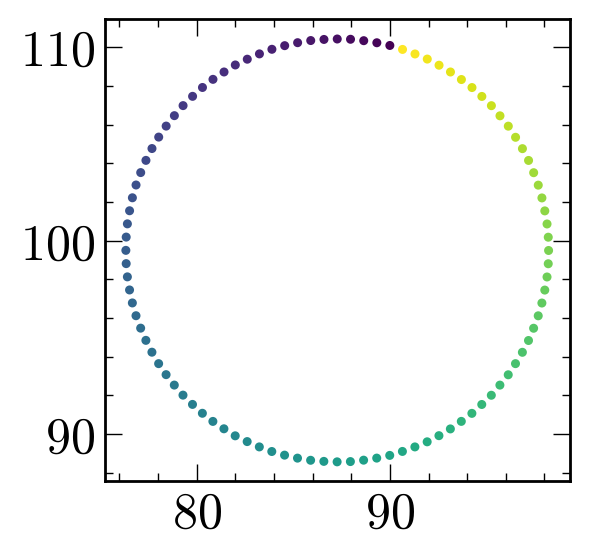

In [26]:
cntr = cell.contour[0][:, ::-1]
cntr = hf.find_contour(cell.phi, interpolate=True, n_pts=100)[0][:, ::-1]
plt.figure(figsize=(3, 3), dpi=200)
plt.scatter(cntr[:, 0], cntr[:, 1], c=range(cntr.shape[0]), s=5)
plt.axis("equal")

### Evolve the cell

In [27]:
cell._prob_type


'none'

In [29]:
from IPython import display
import os

t = []
p_ratio = []
save_path = f"../output/IM/grid_id{gid}/run_0/visuals/"

N = 10000
cap = 250

if not os.path.exists(save_path):
    os.makedirs(save_path)

for n in range(N):
    grad_x, grad_y, _ = hf.compute_gradients(cell.phi, cell.simbox.dx)
    grad_phi = np.array([grad_x, grad_y])
    eta = cell.eta

    if cell.pol_model_kwargs["_pixel_noise"]:
        p_field_next = cell.p_field + polarity.pixel_random_noise(cell, D=0.2)
    else:
        # contour PMF to add mvg patch
        p1 = polarity.cntr_probs_filopodia(cell, grad_phi, chi, delta_l=4)
        p2 = polarity.cntr_probs_feedback(cell, grad_phi)
        if cell._prob_type == "p1":
            cntr_probs = p1
        elif cell._prob_type == "p2":
            cntr_probs = p2
        elif cell._prob_type == "none":
            cntr_probs = None
        else:
            cntr_probs = p1 * p2
            cntr_probs /= cntr_probs.sum()

        # add MVG patch according to a Poisson process
        tau_add = hf._poisson_add_time(cell.rng, cell.pol_model_kwargs["add_rate"])
        picked_c = [np.nan, np.nan]
        mag = 0

        if n % tau_add == 0:
            mag = cell.rng.normal(
                loc=cell.pol_model_kwargs["mag_mean"],
                scale=cell.pol_model_kwargs["mag_std"],
            )
            mvg_patch, picked_c = polarity.mvg_patch(cell, cntr_probs)
            mvg_patch *= mag

        else:
            mvg_patch = 0

        # polarization field (n+1)
        p_field_next = polarity.update_field(
            cell, chi, mvg_patch, cell.pol_model_kwargs
        )

    # phi_(n+1)
    phi_i_next, dF_dphi = hf._update_field(cell, grad_phi, force_calculator)

    if n % cap == 0:
        # display.clear_output(wait=True)
        # t.append(n)
        # cntr = cell.contour[0][:, ::-1] * cell.simbox.dx
        # perim = np.sqrt(np.sum(np.diff(cntr, axis=0) ** 2, axis=1)).sum()
        # p_ratio.append(perim / (2 * np.pi * 4.5))

        # plot_probs(cell, p1, p2, cntr_probs, picked_c, t, p_ratio)

        Figure.view_pol_field(
            cell,
            chi,
            dpi=150,
            path=save_path + f"img_{n//cap}.png",
        )

    # compute motility forces at time n
    fx_motil, fy_motil = force_calculator.cyto_motility_force(cell, grad_phi, chi)

    # compute thermodynamic forces at time n
    fx_thermo = dF_dphi * grad_x
    fy_thermo = dF_dphi * grad_y

    # UPDATE class variables now
    cell.phi = phi_i_next
    cell.p_field = p_field_next
    cell.contour = hf.find_contour(cell.phi, interpolate=cell._cntr_interp)
    cell.cm = hf.compute_CM(cell)
    cell.v_cm = hf.compute_v_CM(cell)
    cell.vx = (fx_thermo + fx_motil) / eta
    cell.vy = (fy_thermo + fy_motil) / eta